<a href="https://colab.research.google.com/github/SvEkaterina/kursovaya_rabota_Svetlichnaya_EA/blob/main/%D0%92%D1%8B%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9_%D0%BD%D0%B0_%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D1%85_%D1%81%D0%BD%D0%B8%D0%BC%D0%BA%D0%B0%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import tensorflow as tf
print("Доступно GPU: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Доступно GPU:  1
2.12.0


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    logical_devices = tf.config.experimental.list_logical_devices('GPU')
    print("Selected GPU:", logical_devices[0])

# Verify that TensorFlow is using the GPU
print(tf.config.experimental.list_logical_devices('GPU'))

Selected GPU: LogicalDevice(name='/device:GPU:0', device_type='GPU')
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [7]:
# Установка библиотеки Kaggle для доступа к датасетам
!pip install -q kaggle

In [8]:
# Загрузка файла kaggle.json для аутентификации
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svetek","key":"14e6be2b391bcf1fa5ea9762fccb605f"}'}

In [9]:
# Создание необходимой директории и изменение прав доступа
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Загрузка датасета
!kaggle datasets download -d nih-chest-xrays/data --force

100% 42.0G/42.0G [05:55<00:00, 157MB/s]
100% 42.0G/42.0G [05:55<00:00, 127MB/s]


In [11]:
# Распаковка в /input
!mkdir /input
!unzip -q data.zip -d /input

In [12]:
# Удаление исходного зип
!rm data.zip

# Предварительная обработка датафрейма
### Чтение данных и очистка

In [13]:
DATA_DIR = '/input/'
image_size = 224
batch_size = 32

In [14]:
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(data_image_paths.get)
len(df)

112120

In [15]:
# Удаление из df всех строк без выявленных заболеваний
df = df[df['Finding Labels']!='No Finding']
len(df)

51759

In [16]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/input/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/input/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/input/images_001/images/00000001_002.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/input/images_001/images/00000003_000.png
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,/input/images_001/images/00000003_001.png


In [17]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]
labels # Переменная labels содержит уникальные значения заболеваний, которые будут использоваться в дальнейшем для классификации изображений в этом датасете

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [18]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [19]:
# Убраем из датасета редкие заболевания, которые не являются значимыми для обучения классификатора и могут негативно повлиять на качество модели
labels = [label for label in labels if df[label].sum() > 1000]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [20]:
# Создаем новый набор данных, содержащий только данные, относящиеся к наиболее распространенным заболеваниям, отобранным на общем фоне, и объединяет их в один DataFrame для дальнейшего анализа и обучения модели.
df_new = pd.DataFrame(columns=df.columns)

for l in labels:
    df_new = pd.concat([df_new, df[df[l]==1][:500]], ignore_index=True)

df_new = df_new.drop_duplicates()
df_new

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000013_030.png,Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumo...,30,13,57,M,AP,2500,2048,0.168000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,00000013_035.png,Atelectasis|Pneumothorax,35,13,56,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,00000019_000.png,Atelectasis|Effusion|Pleural_Thickening,0,19,66,M,PA,2992,2991,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,00000030_000.png,Atelectasis,0,30,74,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,00003002_005.png,Effusion|Pneumothorax,5,3002,34,M,PA,2020,2021,0.194311,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6496,00003002_006.png,Effusion|Pneumothorax,6,3002,34,M,PA,2021,2020,0.194311,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6497,00003005_015.png,Pneumothorax,15,3005,50,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6498,00003005_017.png,Pneumothorax,17,3005,50,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


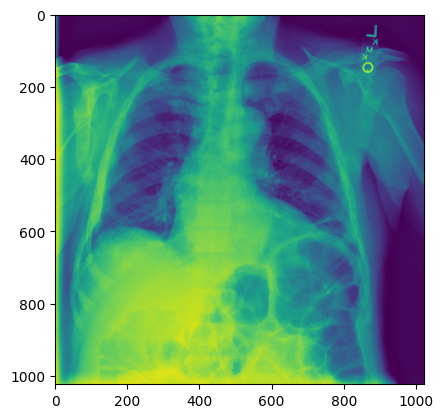

In [21]:
from PIL import Image

# Загрузка изображения
image_path = '/input/images_001/images/00000011_006.png'
image = Image.open(image_path)

# Отображение изображения
plt.imshow(image)
plt.show()

### Разбиение данных

In [22]:
train_df, valid_df = train_test_split(df_new, test_size=0.20, random_state=49, stratify=df_new['Finding Labels'].map(lambda x: x[:4]))

In [23]:
# Разделяет набор данных на две части: тренировочный train_df и валидационный valid_df, обеспечивая случайное, но сбалансированное представление всех классов в каждом из них
train_df.loc[:, 'labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df.loc[:, 'labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

### Определим генератор данных

In [24]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  rotation_range=10,
                                  shear_range=0.1,
                                  fill_mode='nearest',
                                  zoom_range=0.15)

core_idg2 = ImageDataGenerator(rescale=1 / 255)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg2.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=len(valid_df),
                                             classes=labels,
                                             target_size=(image_size, image_size))

X_val, y_val = next(valid_gen)

Found 4051 validated image filenames belonging to 13 classes.
Found 1013 validated image filenames belonging to 13 classes.


# Создание моделей

In [25]:
from keras.applications import DenseNet121

dnet = DenseNet121(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False
    )
dnet.trainable = True

dnet_model = tf.keras.Sequential([
    dnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')])

dnet_model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['AUC','Precision','Recall'])

29084464/29084464 [==============================] - 0s 0us/step


In [26]:
from keras.applications import MobileNet

mnet = MobileNet(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False
    )
mnet.trainable = True

mnet_model = tf.keras.Sequential([
    mnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')])

mnet_model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['AUC','Precision','Recall'])

17225924/17225924 [==============================] - 0s 0us/step


# Обучение моделей

In [27]:
history1 = dnet_model.fit(train_gen,
              validation_data = valid_gen,
              epochs = 15)

Epoch 1/15
127/127 [==============================] - 268s 1s/step - loss: 0.3889 - auc: 0.6326 - precision: 0.2347 - recall: 0.0219 - val_loss: 0.6017 - val_auc: 0.5906 - val_precision: 0.2707 - val_recall: 0.1637
Epoch 2/15
127/127 [==============================] - 113s 886ms/step - loss: 0.3700 - auc: 0.6711 - precision: 0.3840 - recall: 0.0199 - val_loss: 0.4049 - val_auc: 0.6063 - val_precision: 0.2633 - val_recall: 0.0427
Epoch 3/15
127/127 [==============================] - 112s 876ms/step - loss: 0.3595 - auc: 0.7017 - precision: 0.5380 - recall: 0.0366 - val_loss: 0.6677 - val_auc: 0.5253 - val_precision: 0.1860 - val_recall: 0.2104
Epoch 4/15
127/127 [==============================] - 112s 879ms/step - loss: 0.3554 - auc: 0.7153 - precision: 0.5342 - recall: 0.0571 - val_loss: 0.4421 - val_auc: 0.5867 - val_precision: 0.2309 - val_recall: 0.0611
Epoch 5/15
127/127 [==============================] - 116s 909ms/step - loss: 0.3502 - auc: 0.7262 - precision: 0.5661 - recall: 0.

In [28]:
history2 = mnet_model.fit(train_gen,
              validation_data = valid_gen,
              epochs = 15)

Epoch 1/15
127/127 [==============================] - 148s 1s/step - loss: 0.3933 - auc: 0.6604 - precision: 0.3158 - recall: 0.0791 - val_loss: 1.0045 - val_auc: 0.5718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
127/127 [==============================] - 110s 868ms/step - loss: 0.3500 - auc: 0.7315 - precision: 0.5236 - recall: 0.0827 - val_loss: 0.6269 - val_auc: 0.6112 - val_precision: 0.3636 - val_recall: 0.0092
Epoch 3/15
127/127 [==============================] - 110s 866ms/step - loss: 0.3398 - auc: 0.7535 - precision: 0.5746 - recall: 0.0978 - val_loss: 0.4996 - val_auc: 0.6575 - val_precision: 0.7619 - val_recall: 0.0184
Epoch 4/15
127/127 [==============================] - 110s 870ms/step - loss: 0.3323 - auc: 0.7700 - precision: 0.5999 - recall: 0.1249 - val_loss: 0.4280 - val_auc: 0.6921 - val_precision: 0.6098 - val_recall: 0.0288
Epoch 5/15
127/127 [==============================] - 111s 872ms/step - loss: 0.3266 - auc: 0.7811 - precision: 0.5965 - re

### Предсказание моделей

In [29]:
y_pred1 = dnet_model.predict(X_val)
y_pred2 = mnet_model.predict(X_val)

32/32 [==============================] - 2s 40ms/step


In [30]:
print('\n-----DenseNet121-----')
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred1, 0),
                                     100 * np.mean(y_val, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))
    
print('\n-----MobileNet-----')
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred2, 0),
                                     100 * np.mean(y_val, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))


-----DenseNet121-----
Atelectasis: actual: 18.16%, predicted: 19.49%
Cardiomegaly: actual: 10.07%, predicted: 6.60%
Consolidation: actual: 10.86%, predicted: 9.46%
Edema: actual: 10.86%, predicted: 35.79%
Effusion: actual: 19.55%, predicted: 5.78%
Emphysema: actual: 10.17%, predicted: 4.19%
Fibrosis: actual: 9.97%, predicted: 5.57%
Infiltration: actual: 26.65%, predicted: 25.77%
Mass: actual: 11.15%, predicted: 7.89%
Nodule: actual: 11.65%, predicted: 7.03%
Pleural_Thickening: actual: 10.96%, predicted: 4.95%
Pneumonia: actual: 9.28%, predicted: 8.75%
Pneumothorax: actual: 11.94%, predicted: 6.94%

-----MobileNet-----
Atelectasis: actual: 18.16%, predicted: 7.74%
Cardiomegaly: actual: 10.07%, predicted: 4.63%
Consolidation: actual: 10.86%, predicted: 7.12%
Edema: actual: 10.86%, predicted: 7.81%
Effusion: actual: 19.55%, predicted: 5.50%
Emphysema: actual: 10.17%, predicted: 30.97%
Fibrosis: actual: 9.97%, predicted: 6.48%
Infiltration: actual: 26.65%, predicted: 8.88%
Mass: actual: 1

Text(0, 0.5, 'True Positive Rate')

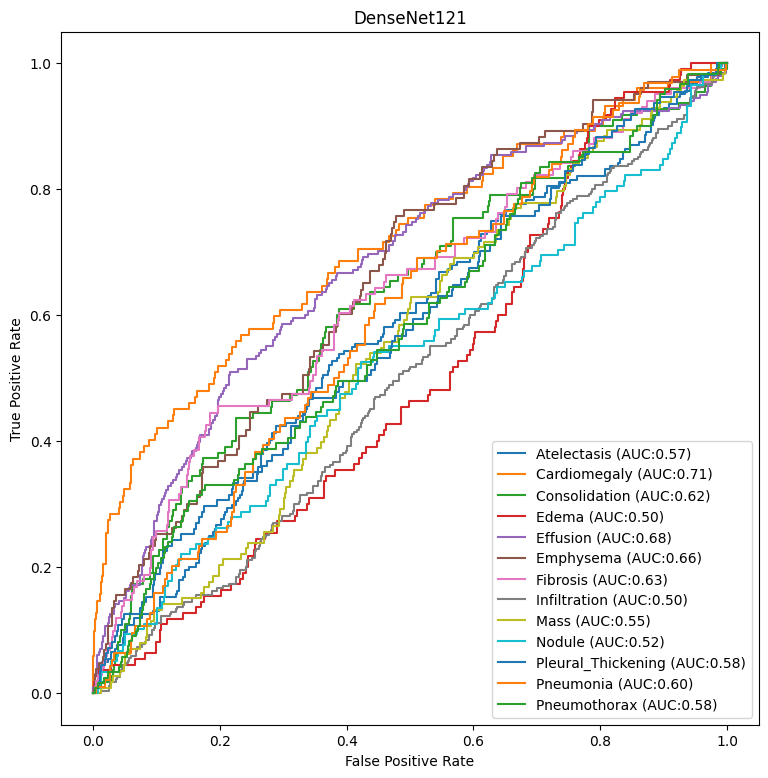

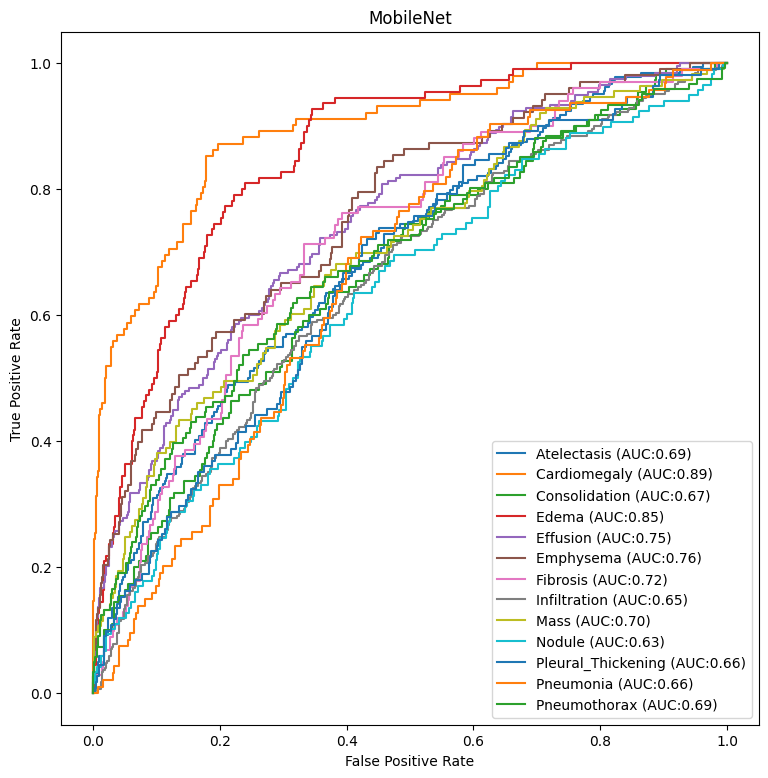

In [31]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
plt.title('DenseNet121')
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_val[:, idx], y_pred1[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
plt.title('MobileNet')
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_val[:, idx], y_pred2[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

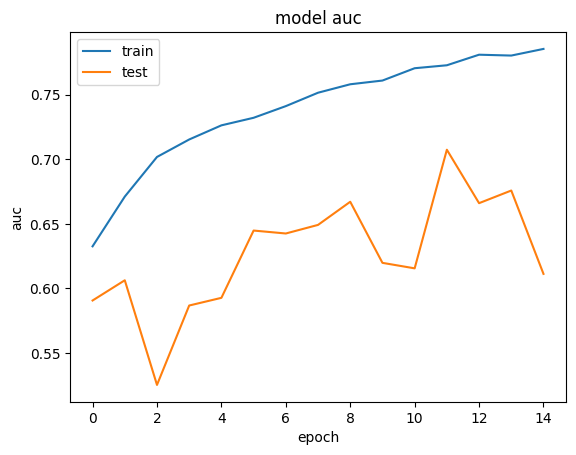

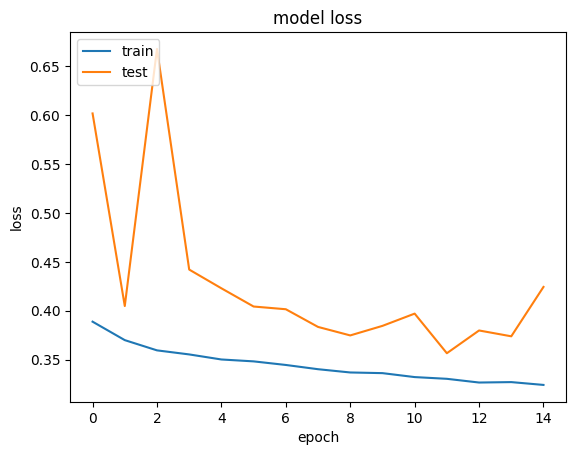

In [32]:
plt.plot(history1.history['auc']) 
plt.plot(history1.history['val_auc']) 
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss']) 
plt.plot(history1.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

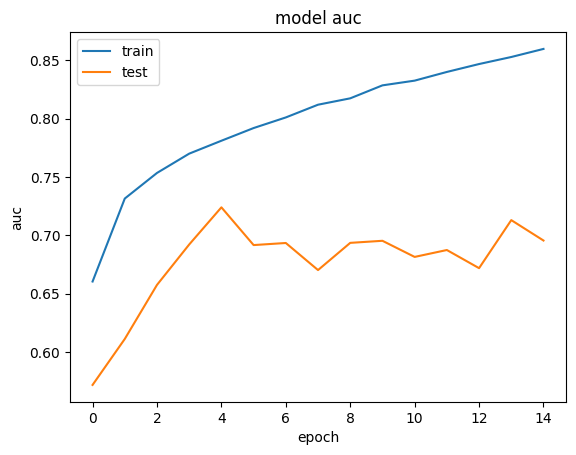

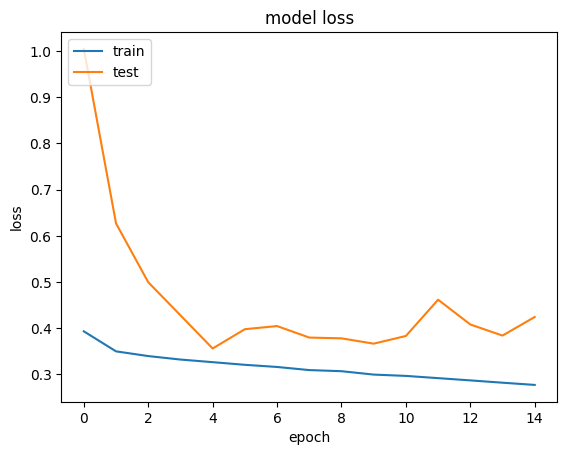

In [33]:
plt.plot(history2.history['auc']) 
plt.plot(history2.history['val_auc']) 
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss']) 
plt.plot(history2.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Выбор лучшей модели и предсказании на изображении

In [34]:
# Вычисление средних значений AUC, Precision, Recall для каждой модели на валидационных данных
avg_auc1 = np.mean(history1.history['val_auc'])
avg_precision1 = np.mean(history1.history['val_precision'])
avg_recall1 = np.mean(history1.history['val_recall'])

avg_auc2 = np.mean(history2.history['val_auc'])
avg_precision2 = np.mean(history2.history['val_precision'])
avg_recall2 = np.mean(history2.history['val_recall'])

# Выбор лучшей модели по среднему значению всех трех метрик
if avg_auc1 + avg_precision1 + avg_recall1 > avg_auc2 + avg_precision2 + avg_recall2:
    best_model = dnet_model
    print("dnet_model лучше")
else:
    best_model = mnet_model
    print("mnet_model лучше")

# Сохранение лучшей модели
best_model.save('best_model.h5')

mnet_model лучше


In [35]:
from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_input(image_path):
    # Загрузка изображения и его предобработка
    image = load_img(image_path, target_size=(224, 224))  # Изменение размера на тот, который использовался при обучении
    image = img_to_array(image)
    
    image_gen = ImageDataGenerator(rescale=1 / 255,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True)
    image = image_gen.standardize(image)
    
    image = np.expand_dims(image, axis=0)
    return image

In [37]:
def predict_disease(image, model):
    # Определение класса болезни
    labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
    pred = model.predict(image)
    return labels[np.argmax(pred)]

Введите путь изображения: /input/images_001/images/00000013_003.png
Начать распознавание? (дa/нет)да
1/1 [==============================] - 1s 758ms/step
Результат: 
Прогнозируемое заболевание: Consolidation


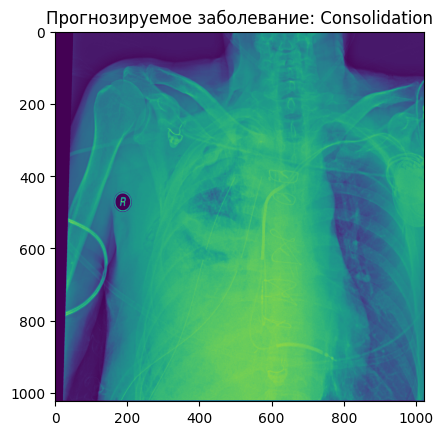

Введите путь изображения: 


In [38]:
def main():
  while True:
    # Загрузка модели
    model = load_model('/content/best_model.h5')

    # Путь к изображению
    image_path = input('Введите путь изображения: ')  #'/input/images_001/images/00000013_003.png' # Использовала пример из датасета
    if image_path == '':
       break
    start_pred = input('Начать распознавание? (дa/нет)')
    if start_pred == 'да':
      # Предобработка и предсказание
      image = preprocess_input(image_path)
      disease = predict_disease(image, model)

      print('Результат: ')
      print(f'Прогнозируемое заболевание: {disease}')
      # Вывод изображения
      image = Image.open(image_path)

      # Отображение изображения
      plt.imshow(image)
      plt.title(f'Прогнозируемое заболевание: {disease}')
      plt.show()
    
main()